In [20]:
#modifying V2 for better accuracies


# Imports

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
from scipy import interpolate
import grafteaux as G
#from tqdm import tqdm 


# Load PIV data

In [23]:
G = reload(G)
mpath = "C:/Users/ksahil/Downloads"
X, Y, U, V,Swirl, Cond,Prof, SwirlFiltPro, SwirlFiltRet, SwirlFilt = G.init_data(mat_path = mpath)
Umean = Prof['U']

current path : C:\Users\ksahil\Anaconda3\envs\machineLearning\python.exe
['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


C:\Users\ksahil\Desktop\SuperResolution\PIVutils.py:27: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(path)
C:\Users\ksahil\Desktop\SuperResolution\PIVutils.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  TempS = {k : f[i][k].value       #Generate a dictionary linking all values in cond with their names


0.2439601862683396


In [24]:
def rf(f):
    '''
    Inverts vector data (f)
    '''
    return [f[len(f)-i-1] for i in range(len(f))]

def lowV3(a, bin_):
    #returns the low res image with a low res size 
    from PIL import Image
    s1, s2 = a.shape[0]//bin_, a.shape[1]//bin_
    return np.array(Image.fromarray(a).resize([s2, s1], resample = Image.BILINEAR))


# pre-processing

In [25]:
data_ins = []
data_outs = []

dim = 15
umean2  = np.array([Umean[:,0] for i in range(U.shape[1])]).T

for i in range(750):
    
    c_frame = U[:,:,i]-umean2
    c_frame = c_frame/np.nanmax(np.abs(c_frame))
    
    do = (c_frame).flatten()
    di = lowV3(c_frame,5).flatten()
    data_ins.append(np.nan_to_num(di))
    data_outs.append(np.nan_to_num(do))

In [26]:
data_outs[0].max()

0.7204151063856532

In [27]:
x_data = np.array(data_ins)
y_data = np.array(data_outs)

In [28]:
ah, bh = umean2.shape
print(ah*bh)
gg = lowV3(umean2,5)
am, bm = np.array(gg.shape)

29766


In [29]:
mid_dim = am*bm
mid_dim

1152

In [30]:
import sklearn
from sklearn.model_selection import train_test_split


In [31]:

xl1_train, xl1_test, xl2_train, xl2_test = train_test_split(y_data, x_data,
                                                            test_size = 0.2,
                                                            shuffle = True,
                                                            random_state = 0)

#xl1 - train data for training phase 1, autoencoder, high res data
#xl2 - data for aux training, low res data

# Autoencoder model 

In [32]:
#write an auto encoder 

from keras import regularizers

mid_dim = am*bm
#output of the encoder. 
#input to the decoder.

hr_in = ah*bh

inputs = keras.Input(shape=(ah*bh,), name="digits")
x1 = layers.Dense(512, activation="tanh")(inputs)
encoded = layers.Dense(mid_dim, activation="relu", 
                      activity_regularizer = regularizers.l1(1e-6))(x1)

encoder = keras.Model(inputs, encoded, name = "Encoder")
#encoder network

x3 = layers.Dense(mid_dim, activation="relu",
                 activity_regularizer = regularizers.l1(1e-6))(encoded)
x4 = layers.Dense(512, activation="relu")(x3)
decoded = layers.Dense(hr_in, activation = "tanh")(x4)

autoencoder = keras.Model(inputs, decoded, name = "AutoEncoder")
#auto enc network

in_decoder = keras.Input(shape = (mid_dim,))

dl1 = autoencoder.layers[-3](in_decoder)
dl2 = autoencoder.layers[-2](dl1)
dl3 = autoencoder.layers[-1](dl2)


decoder = keras.Model(in_decoder, dl3, name = "Decoder")
#decoder network


In [33]:
#train auto encoder
autoencoder.compile(optimizer = 'adam', loss = 'mse')
autoencoder.fit(xl1_train, xl1_train,
               epochs = 100,
               shuffle = True,
               batch_size = 256,
               validation_data = (xl1_test, xl1_test))



Epoch 1/100
3/3 [==============================] - 1s 385ms/step - loss: 0.0457 - val_loss: 0.0447
Epoch 2/100
3/3 [==============================] - 1s 350ms/step - loss: 0.0452 - val_loss: 0.0431
Epoch 3/100
3/3 [==============================] - 1s 332ms/step - loss: 0.0425 - val_loss: 0.0386
Epoch 4/100
3/3 [==============================] - 1s 328ms/step - loss: 0.0381 - val_loss: 0.0364
Epoch 5/100
3/3 [==============================] - 1s 322ms/step - loss: 0.0359 - val_loss: 0.0352
Epoch 6/100
3/3 [==============================] - 1s 325ms/step - loss: 0.0343 - val_loss: 0.0332
Epoch 7/100
3/3 [==============================] - 1s 350ms/step - loss: 0.0324 - val_loss: 0.0318
Epoch 8/100
3/3 [==============================] - 1s 324ms/step - loss: 0.0308 - val_loss: 0.0302
Epoch 9/100
3/3 [==============================] - 1s 319ms/step - loss: 0.0293 - val_loss: 0.0295
Epoch 10/100
3/3 [==============================] - 1s 322ms/step - loss: 0.0281 - val_loss: 0.0284
Epoch 11/

3/3 [==============================] - 1s 334ms/step - loss: 0.0035 - val_loss: 0.0168
Epoch 84/100
3/3 [==============================] - 1s 347ms/step - loss: 0.0034 - val_loss: 0.0167
Epoch 85/100
3/3 [==============================] - 1s 324ms/step - loss: 0.0034 - val_loss: 0.0167
Epoch 86/100
3/3 [==============================] - 1s 323ms/step - loss: 0.0033 - val_loss: 0.0167
Epoch 87/100
3/3 [==============================] - 1s 326ms/step - loss: 0.0032 - val_loss: 0.0167
Epoch 88/100
3/3 [==============================] - 1s 320ms/step - loss: 0.0032 - val_loss: 0.0167
Epoch 89/100
3/3 [==============================] - 1s 321ms/step - loss: 0.0031 - val_loss: 0.0168
Epoch 90/100
3/3 [==============================] - 1s 330ms/step - loss: 0.0031 - val_loss: 0.0168
Epoch 91/100
3/3 [==============================] - 1s 323ms/step - loss: 0.0030 - val_loss: 0.0168
Epoch 92/100
3/3 [==============================] - 1s 324ms/step - loss: 0.0030 - val_loss: 0.0169
Epoch 93/100


In [34]:
#3/3 [==============================] - 1s 324ms/step - loss: 0.0019 - val_loss: 0.0168


# Auxilary network

In [35]:
#get latent rep
x_lat_train = encoder.predict(xl1_train)
x_lat_test = encoder.predict(xl1_test)


In [36]:

#low res to latent network
low_res_in = keras.Input(shape= (am*bm,), name = "low_res")
x5 = layers.Dense(am*bm, activation = "tanh")(low_res_in)
lat_out = layers.Dense(mid_dim, activation = "relu")(x5)

#note --> mid_dim and this a0*b0 should match actually. 

aux_net = keras.Model(low_res_in, lat_out, name = "AuxNet")
#only converts the low res into latent layers


sr_net = decoder(lat_out)
#is this valid?

super_res_net = keras.Model(low_res_in, sr_net, name = "SuperResNet")
#super res network --> converts the low res into hig res network


In [37]:
#train aux loop 
aux_net.compile(optimizer = 'adam', loss = 'mse')

aux_net.fit(xl2_train, x_lat_train,
               epochs = 100,
               shuffle = True,
               batch_size = 256,
               validation_data = (xl2_test, x_lat_test))


Epoch 1/100
3/3 [==============================] - 0s 55ms/step - loss: 0.1803 - val_loss: 0.1198
Epoch 2/100
3/3 [==============================] - 0s 29ms/step - loss: 0.1432 - val_loss: 0.0998
Epoch 3/100
3/3 [==============================] - 0s 29ms/step - loss: 0.1185 - val_loss: 0.0857
Epoch 4/100
3/3 [==============================] - 0s 30ms/step - loss: 0.1009 - val_loss: 0.0757
Epoch 5/100
3/3 [==============================] - 0s 29ms/step - loss: 0.0872 - val_loss: 0.0681
Epoch 6/100
3/3 [==============================] - 0s 30ms/step - loss: 0.0764 - val_loss: 0.0623
Epoch 7/100
3/3 [==============================] - 0s 29ms/step - loss: 0.0676 - val_loss: 0.0576
Epoch 8/100
3/3 [==============================] - 0s 30ms/step - loss: 0.0608 - val_loss: 0.0539
Epoch 9/100
3/3 [==============================] - 0s 32ms/step - loss: 0.0551 - val_loss: 0.0509
Epoch 10/100
3/3 [==============================] - 0s 33ms/step - loss: 0.0503 - val_loss: 0.0484
Epoch 11/100
3/3 [=

Epoch 84/100
3/3 [==============================] - 0s 30ms/step - loss: 0.0064 - val_loss: 0.0479
Epoch 85/100
3/3 [==============================] - 0s 29ms/step - loss: 0.0063 - val_loss: 0.0480
Epoch 86/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0062 - val_loss: 0.0481
Epoch 87/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0061 - val_loss: 0.0482
Epoch 88/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0060 - val_loss: 0.0484
Epoch 89/100
3/3 [==============================] - 0s 29ms/step - loss: 0.0059 - val_loss: 0.0486
Epoch 90/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0058 - val_loss: 0.0486
Epoch 91/100
3/3 [==============================] - 0s 31ms/step - loss: 0.0057 - val_loss: 0.0487
Epoch 92/100
3/3 [==============================] - 0s 32ms/step - loss: 0.0056 - val_loss: 0.0488
Epoch 93/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0055 - val_loss: 0.0489
Epoch 94/1

# Autoencoder plots

Text(0.5, 1.0, 'original input')

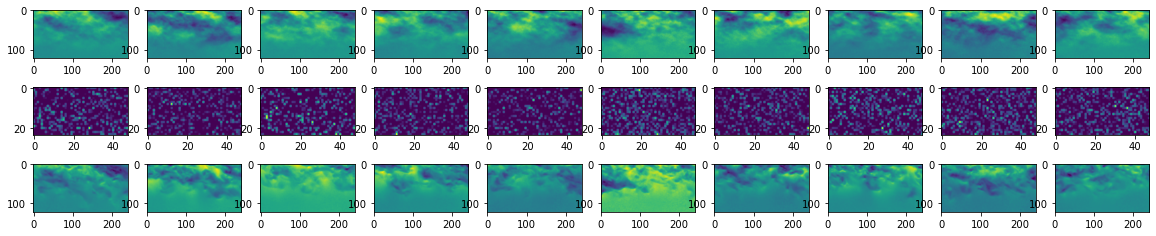

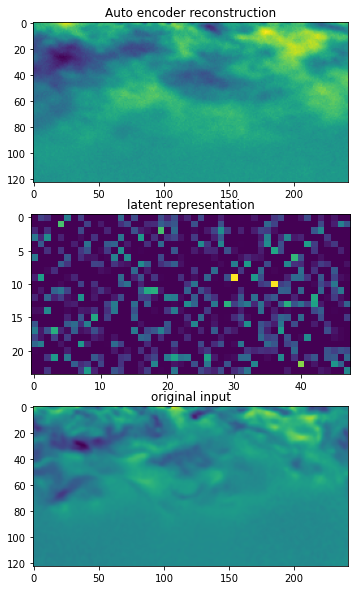

In [39]:
#IMMA PLOT the first 10 true image, encoded images, (latent representations), and finally latent. 

encoded_images = encoder.predict(xl1_test)
decoded_images = decoder.predict(encoded_images)


n = 10
plt.figure(figsize = (20,4))
for i in range(10):
    plt.subplot(3,n,i+1)
    plt.imshow(decoded_images[i].reshape(umean2.shape))
    
    plt.subplot(3,n,i+1+n)
    plt.imshow(encoded_images[i].reshape([am,bm]))
    
    plt.subplot(3,n,i+1+2*n)
    plt.imshow(xl1_test[i].reshape(umean2.shape))
    
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.imshow(decoded_images[i].reshape(umean2.shape))
plt.title('Auto encoder reconstruction')
plt.subplot(3,1,2)
plt.imshow(encoded_images[i].reshape([am,bm]))
plt.title('latent representation')
plt.subplot(3,1,3)
plt.imshow(xl1_test[i].reshape(umean2.shape))
plt.title('original input')

    

# super rersolutution plots

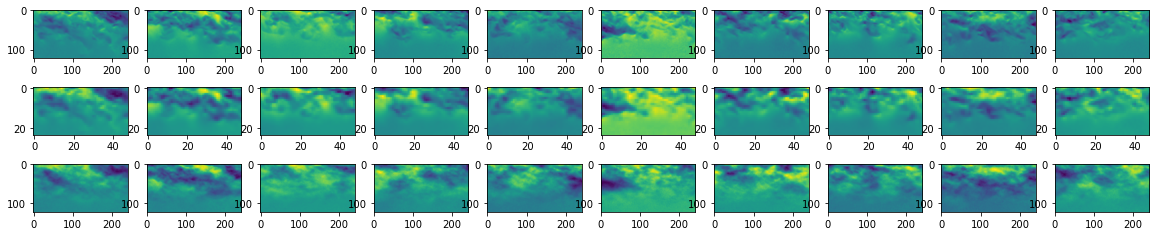

In [40]:
super_hr = super_res_net.predict(xl2_test)

n = 10
plt.figure(figsize = (20,4))
for i in range(10):
    plt.subplot(3,n,i+1)
    plt.imshow(xl1_test[i].reshape(umean2.shape))
    
    plt.subplot(3,n,i+1+n)
    plt.imshow(xl2_test[i].reshape([am,bm]))
    
    plt.subplot(3,n,i+1+2*n)
    plt.imshow(super_hr[i].reshape(umean2.shape))
    

In [41]:
def L2_fuk(U_og, U_rc):
    return np.linalg.norm(U_og-U_rc, ord = 'fro')/np.linalg.norm(U_og, ord = 'fro')

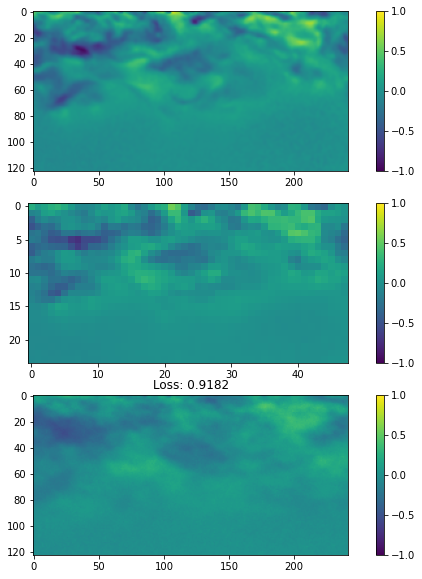

In [42]:
Utest_og = xl1_test[i].reshape(umean2.shape)
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.imshow(Utest_og, clim = [-1,1])
plt.colorbar()

plt.subplot(3,1,2)
plt.imshow(xl2_test[i].reshape([am,bm]), clim = [-1,1])
plt.colorbar()

Utest_rc = super_hr[i].reshape(umean2.shape)
U_loss = float(L2_fuk(Utest_rc, Utest_og))

plt.subplot(3,1,3)
plt.imshow(Utest_rc, clim = [-1,1])
plt.colorbar()
plt.title('Loss: %.4f'%(U_loss))
plt.show()

# performance of SR + AutoEncoder network

In [43]:
#evaluate performance. 
autoSR_score = np.mean([L2_fuk(super_hr[i].reshape(umean2.shape),
                               xl1_test[i].reshape(umean2.shape))
                        for i in range(len(xl1_test))])
autoSR_score

0.7469383095858366

# Comparing the stand alone Super resolution network

In [44]:
#create dummy sr network for verification and comparision against autoSR
decoder = keras.Sequential(name = "Decoder")
decoder.add(keras.Input(shape=(am*bm,)))

sr_dum = keras.Sequential(name = "SR_dum")
sr_dum.add(keras.Input(shape=(am*bm,)))
sr_dum.add(layers.Dense(am*bm, activation = "tanh"))
sr_dum.add(layers.Dense(am*bm, activation = "tanh"))
sr_dum.add(layers.Dense(am*bm, activation = "relu"))
sr_dum.add(layers.Dense(512, activation = "relu"))
sr_dum.add(layers.Dense(ah*bh, activation = "tanh"))


In [45]:
sr_dum.compile(optimizer = 'adam', loss = 'mse')
sr_history = sr_dum.fit(xl2_train, xl1_train,
               epochs = 100,
               shuffle = True,
               batch_size = 256,
               validation_data = (xl2_test, xl1_test))

Epoch 1/100
3/3 [==============================] - 1s 270ms/step - loss: 0.0456 - val_loss: 0.0444
Epoch 2/100
3/3 [==============================] - 1s 235ms/step - loss: 0.0447 - val_loss: 0.0418
Epoch 3/100
3/3 [==============================] - 1s 231ms/step - loss: 0.0412 - val_loss: 0.0372
Epoch 4/100
3/3 [==============================] - 1s 233ms/step - loss: 0.0366 - val_loss: 0.0353
Epoch 5/100
3/3 [==============================] - 1s 235ms/step - loss: 0.0346 - val_loss: 0.0331
Epoch 6/100
3/3 [==============================] - 1s 234ms/step - loss: 0.0323 - val_loss: 0.0310
Epoch 7/100
3/3 [==============================] - 1s 236ms/step - loss: 0.0301 - val_loss: 0.0290
Epoch 8/100
3/3 [==============================] - 1s 234ms/step - loss: 0.0278 - val_loss: 0.0274
Epoch 9/100
3/3 [==============================] - 1s 235ms/step - loss: 0.0261 - val_loss: 0.0261
Epoch 10/100
3/3 [==============================] - 1s 237ms/step - loss: 0.0247 - val_loss: 0.0251
Epoch 11/

3/3 [==============================] - 1s 251ms/step - loss: 0.0030 - val_loss: 0.0116
Epoch 84/100
3/3 [==============================] - 1s 237ms/step - loss: 0.0030 - val_loss: 0.0116
Epoch 85/100
3/3 [==============================] - 1s 230ms/step - loss: 0.0029 - val_loss: 0.0117
Epoch 86/100
3/3 [==============================] - 1s 232ms/step - loss: 0.0029 - val_loss: 0.0117
Epoch 87/100
3/3 [==============================] - 1s 228ms/step - loss: 0.0028 - val_loss: 0.0117
Epoch 88/100
3/3 [==============================] - 1s 230ms/step - loss: 0.0028 - val_loss: 0.0118
Epoch 89/100
3/3 [==============================] - 1s 233ms/step - loss: 0.0028 - val_loss: 0.0118
Epoch 90/100
3/3 [==============================] - 1s 247ms/step - loss: 0.0028 - val_loss: 0.0118
Epoch 91/100
3/3 [==============================] - 1s 236ms/step - loss: 0.0027 - val_loss: 0.0119
Epoch 92/100
3/3 [==============================] - 1s 237ms/step - loss: 0.0027 - val_loss: 0.0118
Epoch 93/100


In [46]:
sr_dum_pd = sr_dum.predict(xl2_test)

sr_dum_score = np.mean([L2_fuk(sr_dum_pd[i].reshape(umean2.shape),
                               xl1_test[i].reshape(umean2.shape))
                        for i in range(len(xl1_test))])
sr_dum_score

0.6065391423945656

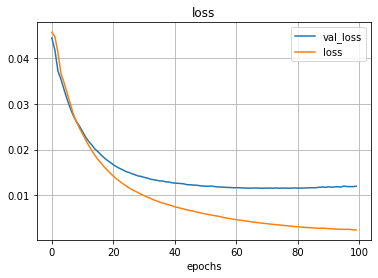

In [47]:
plt.figure()
plt.plot(sr_history.history['val_loss'], label = 'val_loss')
plt.plot(sr_history.history['loss'], label = 'loss')
plt.title('loss')
plt.legend()
plt.xlabel('epochs')
plt.grid()